In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE  # imblearn library can be installed using pip install imblearn
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import SGDClassifier


In [2]:
# Importing dataset and examining it
dataset = pd.read_csv(r"C:\Users\Aniket\Downloads\tour_package.csv")
pd.set_option('display.max_columns', None) # to make sure you can see all the columns in output window

In [3]:
dataset.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


In [4]:
print(print(dataset.columns))
print('---------')
print('Shape:',dataset.shape)

Index(['CustomerID', 'ProdTaken', 'Age', 'TypeofContact', 'CityTier',
       'DurationOfPitch', 'Occupation', 'Gender', 'NumberOfPersonVisiting',
       'NumberOfFollowups', 'ProductPitched', 'PreferredPropertyStar',
       'MaritalStatus', 'NumberOfTrips', 'Passport', 'PitchSatisfactionScore',
       'OwnCar', 'NumberOfChildrenVisiting', 'Designation', 'MonthlyIncome'],
      dtype='object')
None
---------
Shape: (4888, 20)


# Data Pre-processing 

In [5]:
# Dropping the CustomerID column
dataset.drop('CustomerID', axis=1, inplace=True)


In [6]:
dataset.dropna(inplace=True)

In [7]:
def cat_feature(dataframe):
    '''To Check The Category column in Data frame'''
    cat=[]
    for col in dataframe.columns:
        if dataset[col].dtype == 'object':
            cat.append(col)
    return cat 

In [8]:
def unique_feature_values_and_counts(Dataframe, columns):
    unique_values_with_counts = []
    for feature in columns:
        value_counts = Dataframe[feature].value_counts()
        unique_values_with_counts.append(
            (feature, value_counts, '\n')
        )
    return unique_values_with_counts


In [9]:
unique_feature_values_and_counts(dataset,cat_feature(dataset))

[('TypeofContact',
  Self Enquiry       2918
  Company Invited    1210
  Name: TypeofContact, dtype: int64,
  '\n'),
 ('Occupation',
  Salaried          1999
  Small Business    1746
  Large Business     381
  Free Lancer          2
  Name: Occupation, dtype: int64,
  '\n'),
 ('Gender',
  Male       2463
  Female     1510
  Fe Male     155
  Name: Gender, dtype: int64,
  '\n'),
 ('ProductPitched',
  Basic           1615
  Deluxe          1422
  Standard         737
  Super Deluxe     250
  King             104
  Name: ProductPitched, dtype: int64,
  '\n'),
 ('MaritalStatus',
  Married      1990
  Divorced      789
  Unmarried     682
  Single        667
  Name: MaritalStatus, dtype: int64,
  '\n'),
 ('Designation',
  Executive         1615
  Manager           1422
  Senior Manager     737
  AVP                250
  VP                 104
  Name: Designation, dtype: int64,
  '\n')]

#### 1. Female and Fe male are same category , Data needs to be fixed
#### 2. Single and unmarried status are not same category . Unmarried here means customers having partners.

In [10]:
dataset['Gender'] = dataset['Gender'].apply(lambda x: 'Female' if x == 'Fe Male' else x)


In [11]:
dataset['MaritalStatus']=dataset['MaritalStatus'].apply(lambda x: 'Single' if x == 'Unmarried' else x)

In [12]:
print(dataset['Gender'].value_counts())
print("_________________________________")
print(dataset['MaritalStatus'].value_counts())

Male      2463
Female    1665
Name: Gender, dtype: int64
_________________________________
Married     1990
Single      1349
Divorced     789
Name: MaritalStatus, dtype: int64


In [13]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4128 entries, 0 to 4887
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ProdTaken                 4128 non-null   int64  
 1   Age                       4128 non-null   float64
 2   TypeofContact             4128 non-null   object 
 3   CityTier                  4128 non-null   int64  
 4   DurationOfPitch           4128 non-null   float64
 5   Occupation                4128 non-null   object 
 6   Gender                    4128 non-null   object 
 7   NumberOfPersonVisiting    4128 non-null   int64  
 8   NumberOfFollowups         4128 non-null   float64
 9   ProductPitched            4128 non-null   object 
 10  PreferredPropertyStar     4128 non-null   float64
 11  MaritalStatus             4128 non-null   object 
 12  NumberOfTrips             4128 non-null   float64
 13  Passport                  4128 non-null   int64  
 14  PitchSat

In [14]:
dataset.isnull().sum()

ProdTaken                   0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch             0
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
MaritalStatus               0
NumberOfTrips               0
Passport                    0
PitchSatisfactionScore      0
OwnCar                      0
NumberOfChildrenVisiting    0
Designation                 0
MonthlyIncome               0
dtype: int64

In [15]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
ProdTaken,4128.0,0.193072,0.394757,0.0,0.0,0.0,0.0,1.0
Age,4128.0,37.231831,9.174521,18.0,31.0,36.0,43.0,61.0
CityTier,4128.0,1.663275,0.920640,1.0,1.0,1.0,3.0,3.0
DurationOfPitch,4128.0,15.584787,8.398142,5.0,9.0,14.0,20.0,127.0
NumberOfPersonVisiting,4128.0,2.949370,0.718818,1.0,2.0,3.0,3.0,5.0
NumberOfFollowups,4128.0,3.741521,1.006786,1.0,3.0,4.0,4.0,6.0
PreferredPropertyStar,4128.0,3.578488,0.795031,3.0,3.0,3.0,4.0,5.0
NumberOfTrips,4128.0,3.295300,1.856300,1.0,2.0,3.0,4.0,22.0
Passport,4128.0,0.295300,0.456233,0.0,0.0,0.0,1.0,1.0
PitchSatisfactionScore,4128.0,3.060804,1.363064,1.0,2.0,3.0,4.0,5.0


# Exploratory data analysis

##### 1. Univariate Analysis

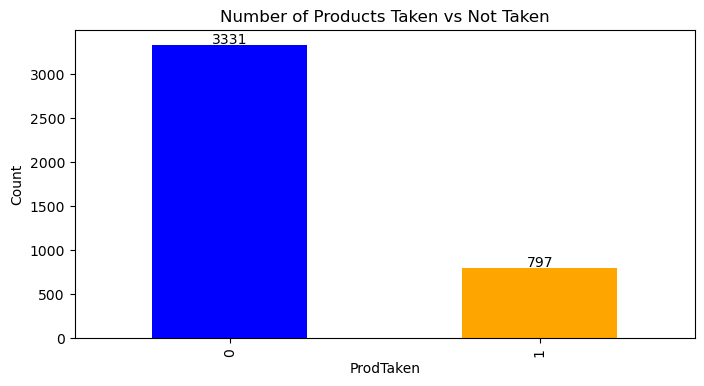

In [16]:
# Count the number of products taken
prod_taken_counts = dataset['ProdTaken'].value_counts()

# Create a bar plot using matplotlib
fig, ax = plt.subplots(figsize=(8, 4))
prod_taken_counts.plot(kind='bar', ax=ax, color=['blue', 'orange'])

# Add value labels to the bars
for i, v in enumerate(prod_taken_counts):
    ax.text(i, v + 10, str(v), color='black', ha='center')

# Set the plot title and axis labels
ax.set_title('Number of Products Taken vs Not Taken')
ax.set_xlabel('ProdTaken')
ax.set_ylabel('Count')

plt.show()


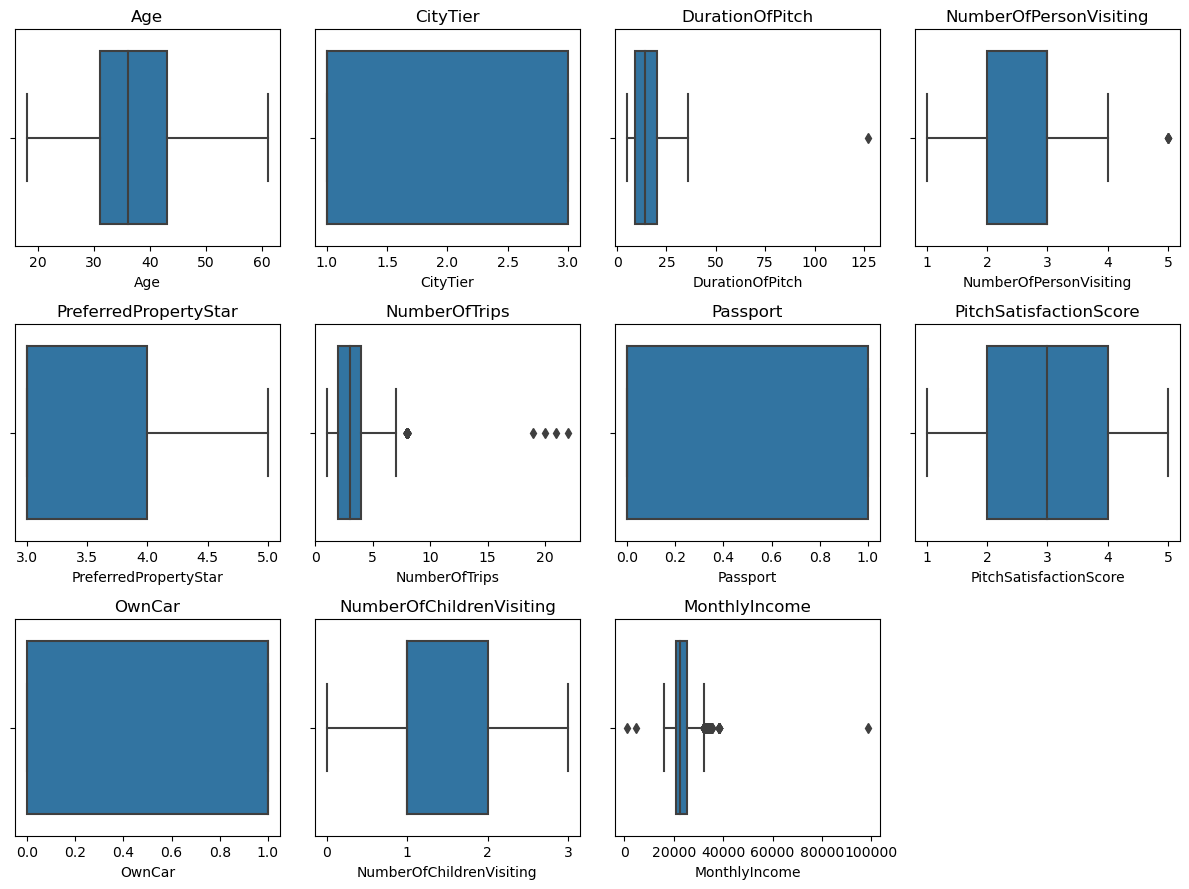

In [17]:
features = ['Age', 'CityTier', 'DurationOfPitch', 'NumberOfPersonVisiting',
            'PreferredPropertyStar', 'NumberOfTrips', 'Passport', 'PitchSatisfactionScore',
            'OwnCar', 'NumberOfChildrenVisiting', 'MonthlyIncome']

fig, axs = plt.subplots(3, 4, figsize=(12, 9))  
axs = axs.flatten()

for i, feature in enumerate(features):
    sns.boxplot(x=dataset[feature], ax=axs[i])
    axs[i].set_title(feature)
axs[-1].set_visible(False)

plt.tight_layout()
plt.show()


#### 2.Bivariate & Multivariate Analysis

<AxesSubplot:>

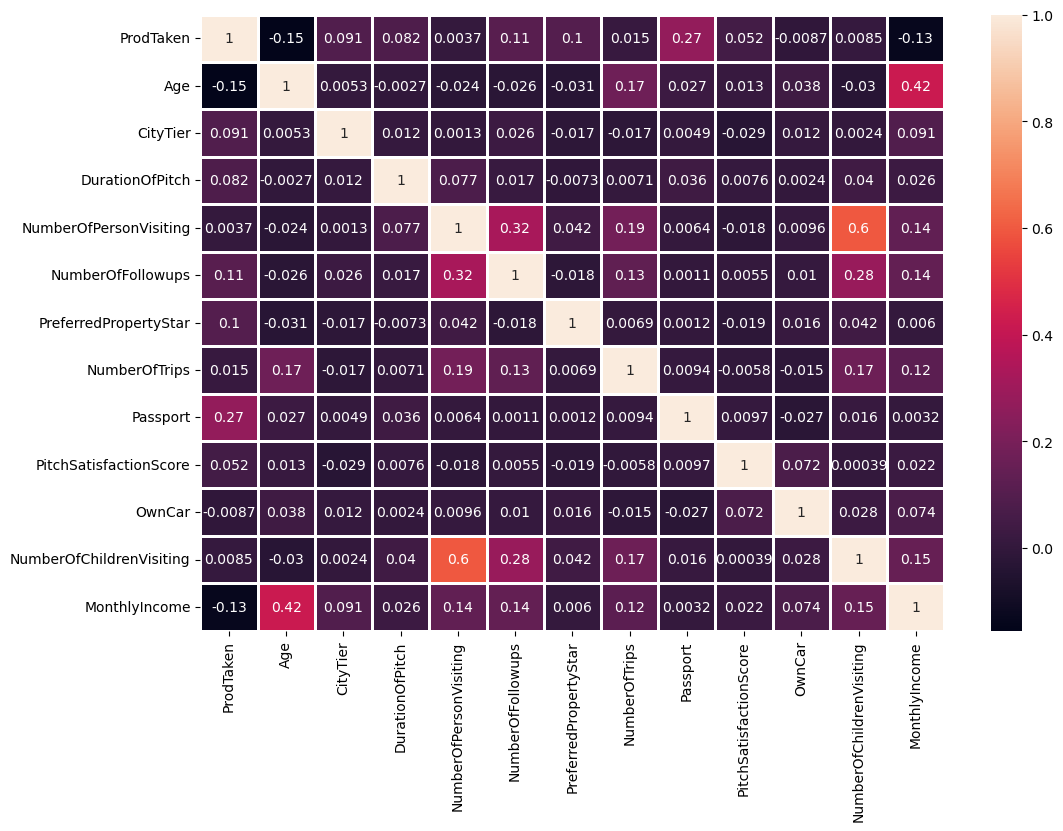

In [18]:
dataset.corr()
plt.figure(figsize=(12,8))
sns.heatmap(data=dataset.corr(),annot=True,linewidths=2)

In [19]:
cat_feature(dataset)

['TypeofContact',
 'Occupation',
 'Gender',
 'ProductPitched',
 'MaritalStatus',
 'Designation']

### Label encoading/ Manual encoading 

In [20]:
# Converting Categorical features into Numerical features
dataset['TypeofContact'] = dataset['TypeofContact'].map({'Self Enquiry':1, 'Company Invited':0})
dataset['Occupation'] = dataset['Occupation'].map({'Free Lancer':1, 'Salaried':2, 'Small Business':3, 'Large Business':4})
dataset['Gender'] = dataset['Gender'].map({'Female':1, 'Male':0})
dataset['Designation'] = dataset['Designation'].map({'Executive':0, 'Manager':1, 'Senior Manager':2, 'AVP':3, 'VP':4})
marital_status_mapping = {'Married': 0, 'Single': 1, 'Divorced': 2}
dataset['MaritalStatus'] = dataset['MaritalStatus'].map(marital_status_mapping)
product_pitched_mapping = {
    'Basic': 0,
    'Deluxe': 1,
    'Standard': 2,
    'Super Deluxe': 3,
    'King': 4
}
dataset['ProductPitched'] = dataset['ProductPitched'].map(product_pitched_mapping)


In [21]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4128 entries, 0 to 4887
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ProdTaken                 4128 non-null   int64  
 1   Age                       4128 non-null   float64
 2   TypeofContact             4128 non-null   int64  
 3   CityTier                  4128 non-null   int64  
 4   DurationOfPitch           4128 non-null   float64
 5   Occupation                4128 non-null   int64  
 6   Gender                    4128 non-null   int64  
 7   NumberOfPersonVisiting    4128 non-null   int64  
 8   NumberOfFollowups         4128 non-null   float64
 9   ProductPitched            4128 non-null   int64  
 10  PreferredPropertyStar     4128 non-null   float64
 11  MaritalStatus             4128 non-null   int64  
 12  NumberOfTrips             4128 non-null   float64
 13  Passport                  4128 non-null   int64  
 14  PitchSat

In [22]:
final_data=dataset

In [23]:
# Dividing dataset into label and feature sets
X = final_data.drop('ProdTaken', axis = 1) # Features
Y = final_data['ProdTaken'] # Labels
print(type(X))
print(type(Y))
print(X.shape)
print(Y.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(4128, 18)
(4128,)


In [24]:
from sklearn.model_selection import train_test_split
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.2, random_state=42)

print('Length of X Train :', len(X_Train))
print('Length of X Test  :', len(X_Test))
print('Length of Y Train :', len(Y_Train))
print('Length of Y Test  :', len(Y_Test))


Length of X Train : 3302
Length of X Test  : 826
Length of Y Train : 3302
Length of Y Test  : 826


## Model :-1 ( LR)

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score,classification_report
from sklearn.metrics import roc_curve, auc,ConfusionMatrixDisplay,roc_auc_score
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
lr = LogisticRegression(max_iter=1000)
lr.fit(X_Train, Y_Train)

y_pred = lr.predict(X_Test)

lr_train_acc = accuracy_score(Y_Train, lr.predict(X_Train))
lr_test_acc = accuracy_score(Y_Test, y_pred)
cohen_kappa = cohen_kappa_score(Y_Test, y_pred)

print(f"Training accuracy of Logistic Regression is : {lr_train_acc}")
print(f"Test accuracy of Logistic Regression is : {lr_test_acc}")
print(f"Logistic Regression cohen_kappa_score : {cohen_kappa}")


Training accuracy of Logistic Regression is : 0.8376741368867353
Test accuracy of Logistic Regression is : 0.8353510895883777
Logistic Regression cohen_kappa_score : 0.2961491710630192


[[652   9]
 [127  38]]
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       661
           1       0.81      0.23      0.36       165

    accuracy                           0.84       826
   macro avg       0.82      0.61      0.63       826
weighted avg       0.83      0.84      0.80       826



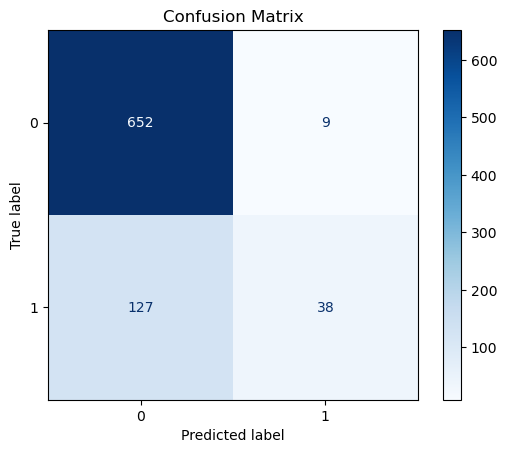

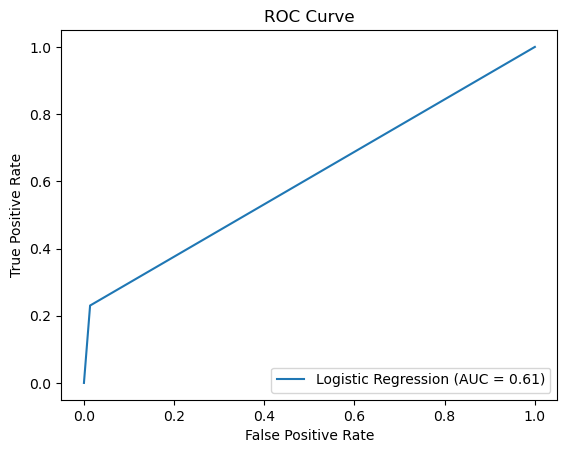

In [32]:
print(confusion_matrix(Y_Test, y_pred))
print(classification_report(Y_Test, y_pred))
# Plot confusion matrix
cm = confusion_matrix(Y_Test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()
# ROC 
fpr, tpr, thresholds = roc_curve(Y_Test, y_pred, pos_label=1)
roc_auc = roc_auc_score(Y_Test, y_pred)

disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
disp.plot()
plt.title("ROC Curve")
plt.show()

## Model 2(Random Forest)

Training accuracy of Random Forest is : 0.9569957601453665
Test accuracy of Random Forest is : 0.9007263922518159
RF cohen_kappa_score : 0.6286989222554791
[[656   5]
 [ 77  88]]
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       661
           1       0.95      0.53      0.68       165

    accuracy                           0.90       826
   macro avg       0.92      0.76      0.81       826
weighted avg       0.91      0.90      0.89       826



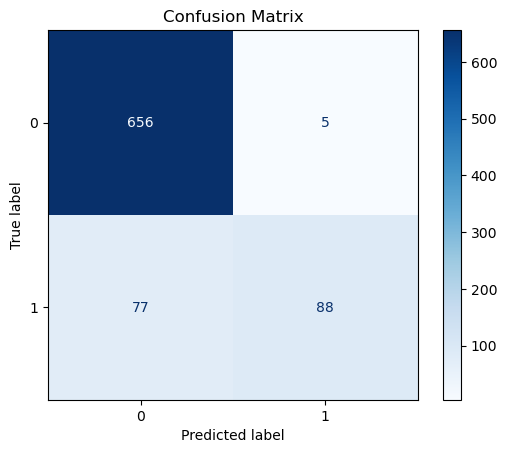

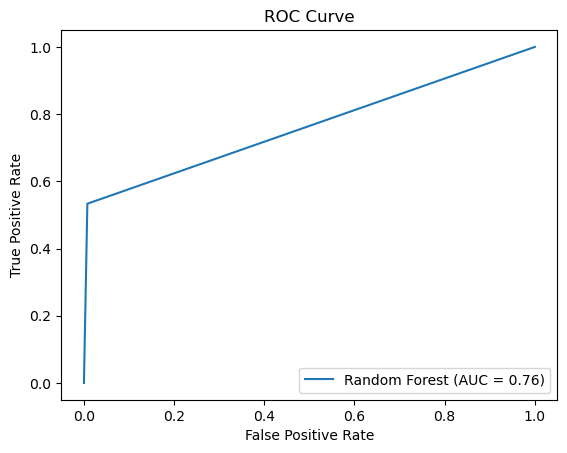

In [33]:
from sklearn.ensemble import RandomForestClassifier

rand_clf = RandomForestClassifier()
rand_clf.fit(X_Train, Y_Train)

y_pred = rand_clf.predict(X_Test)
# Define the model
best_rfc = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Train the model
best_rfc.fit(X_Train, Y_Train)

# Make predictions on the testing set
y_pred = best_rfc.predict(X_Test)

# Calculate accuracy and other metrics
rand_clf_train_acc = accuracy_score(Y_Train, best_rfc.predict(X_Train))
rand_clf_test_acc = accuracy_score(Y_Test, y_pred)
cohen_kappa = cohen_kappa_score(Y_Test, y_pred)

print(f"Training accuracy of Random Forest is : {rand_clf_train_acc}")
print(f"Test accuracy of Random Forest is : {rand_clf_test_acc}")
print(f"RF cohen_kappa_score : {cohen_kappa}")

print(confusion_matrix(Y_Test, y_pred))

print(classification_report(Y_Test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(Y_Test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rfc.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(Y_Test, y_pred, pos_label=1)
roc_auc = roc_auc_score(Y_Test, y_pred)



disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Random Forest')
disp.plot()
plt.title("ROC Curve")
plt.show()


### Model 3 (ADA BOOST)

Training accuracy of AdaBoost is : 0.8558449424591157
Test accuracy of AdaBoost is : 0.8365617433414043
AdaBoost cohen_kappa_score : 0.37685111709677777
[[633  28]
 [107  58]]
              precision    recall  f1-score   support

           0       0.86      0.96      0.90       661
           1       0.67      0.35      0.46       165

    accuracy                           0.84       826
   macro avg       0.76      0.65      0.68       826
weighted avg       0.82      0.84      0.82       826



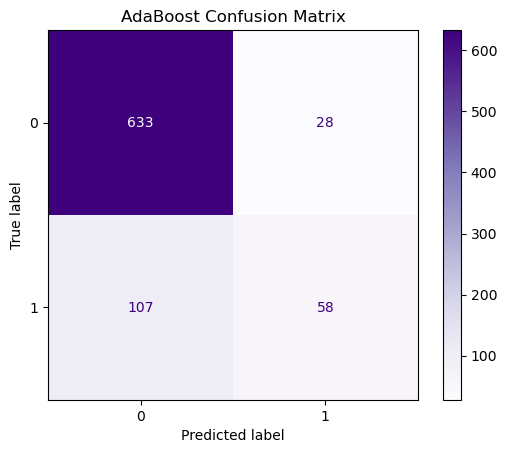

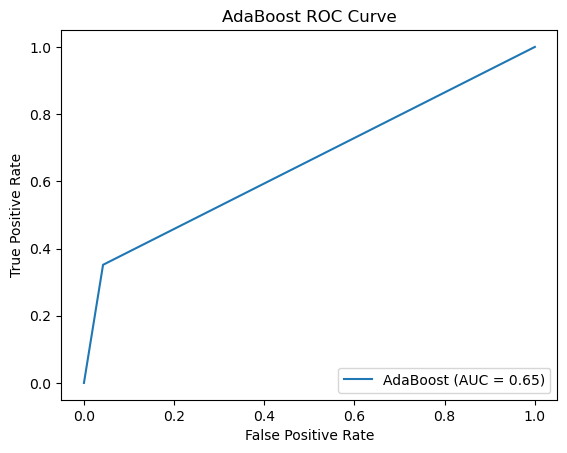

In [34]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# Define the AdaBoost model
ada_clf = AdaBoostClassifier(n_estimators=100, random_state=42)

# Train the model
ada_clf.fit(X_Train, Y_Train)

# Make predictions on the testing set
y_pred_ada = ada_clf.predict(X_Test)

# Calculate accuracy and other metrics for AdaBoost
ada_train_acc = accuracy_score(Y_Train, ada_clf.predict(X_Train))
ada_test_acc = accuracy_score(Y_Test, y_pred_ada)
ada_cohen_kappa = cohen_kappa_score(Y_Test, y_pred_ada)

print(f"Training accuracy of AdaBoost is : {ada_train_acc}")
print(f"Test accuracy of AdaBoost is : {ada_test_acc}")
print(f"AdaBoost cohen_kappa_score : {ada_cohen_kappa}")

# Print confusion matrix and classification report
print(confusion_matrix(Y_Test, y_pred_ada))
print(classification_report(Y_Test, y_pred_ada))

# Plot confusion matrix for AdaBoost
cm_ada = confusion_matrix(Y_Test, y_pred_ada)
disp_ada = ConfusionMatrixDisplay(confusion_matrix=cm_ada, display_labels=ada_clf.classes_)
disp_ada.plot(cmap=plt.cm.Purples)
plt.title("AdaBoost Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# Plot ROC curve for AdaBoost
fpr_ada, tpr_ada, thresholds_ada = roc_curve(Y_Test, y_pred_ada, pos_label=1)
roc_auc_ada = roc_auc_score(Y_Test, y_pred_ada)

disp_ada = RocCurveDisplay(fpr=fpr_ada, tpr=tpr_ada, roc_auc=roc_auc_ada, estimator_name='AdaBoost')
disp_ada.plot()
plt.title("AdaBoost ROC Curve")
plt.show()


## Model 4 ( Support Vector Machine)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# Define the SVM model
svm_clf = SVC(kernel='linear', probability=True, random_state=42)  # You can change the kernel as needed

# Train the model
svm_clf.fit(X_Train, Y_Train)

# Make predictions on the testing set
y_pred_svm = svm_clf.predict(X_Test)

# Calculate accuracy and other metrics for SVM
svm_train_acc = accuracy_score(Y_Train, svm_clf.predict(X_Train))
svm_test_acc = accuracy_score(Y_Test, y_pred_svm)
svm_cohen_kappa = cohen_kappa_score(Y_Test, y_pred_svm)

print(f"Training accuracy of SVM is : {svm_train_acc}")
print(f"Test accuracy of SVM is : {svm_test_acc}")
print(f"SVM cohen_kappa_score : {svm_cohen_kappa}")

# Print confusion matrix and classification report
print(confusion_matrix(Y_Test, y_pred_svm))
print(classification_report(Y_Test, y_pred_svm))

# Plot confusion matrix for SVM
cm_svm = confusion_matrix(Y_Test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp_svm.plot(cmap=plt.cm.Greens)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# Since SVM is not inherently a binary classifier, we use decision_function or predict_proba to get the scores
svm_scores = svm_clf.decision_function(X_Test)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(Y_Test, svm_scores)

# Calculate ROC AUC for SVM
roc_auc_svm = roc_auc_score(Y_Test, svm_scores)

# Plot ROC curve for SVM
disp_svm = RocCurveDisplay(fpr=fpr_svm, tpr=tpr_svm, roc_auc=roc_auc_svm, estimator_name='SVM')
disp_svm.plot()
plt.title("SVM ROC Curve")
plt.show()



## Model 5(gradient boosting)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# Define the Gradient Boosting model
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model on the training set
gb_clf.fit(X_Train, Y_Train)

# Make predictions on the test set
y_pred_gb = gb_clf.predict(X_Test)

# Calculate accuracy and other metrics for Gradient Boosting
gb_train_acc = accuracy_score(Y_Train, gb_clf.predict(X_Train))
gb_test_acc = accuracy_score(Y_Test, y_pred_gb)
gb_cohen_kappa = cohen_kappa_score(Y_Test, y_pred_gb)

print(f"Training accuracy of Gradient Boosting is: {gb_train_acc}")
print(f"Test accuracy of Gradient Boosting is: {gb_test_acc}")
print(f"Gradient Boosting cohen_kappa_score: {gb_cohen_kappa}")

# Print confusion matrix and classification report
print(confusion_matrix(Y_Test, y_pred_gb))
print(classification_report(Y_Test, y_pred_gb))

# Plot confusion matrix for Gradient Boosting
cm_gb = confusion_matrix(Y_Test, y_pred_gb)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb)
disp_gb.plot(cmap=plt.cm.Oranges)
plt.title("Gradient Boosting Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# For binary classification, use predict_proba to get the scores for ROC
# For multiclass, you need to adapt this code to handle multiclass ROC analysis
if len(gb_clf.classes_) == 2:
    gb_scores = gb_clf.predict_proba(X_Test)[:, 1]
    fpr_gb, tpr_gb, thresholds_gb = roc_curve(Y_Test, gb_scores)
    roc_auc_gb = roc_auc_score(Y_Test, gb_scores)

    # Plot ROC curve for Gradient Boosting
    disp_gb = RocCurveDisplay(fpr=fpr_gb, tpr=tpr_gb, roc_auc=roc_auc_gb, estimator_name='Gradient Boosting')
    disp_gb.plot()
    plt.title("Gradient Boosting ROC Curve")
    plt.show()
else:
    print("ROC curve is not plotted because this is not a binary classification problem.")
